In [3]:
import os
import tweepy as tw
import pandas as pd

# To  visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
import plotly.express as px

# To process the text
import nltk
from nltk import bigrams
from nltk import bigrams as nltk_bigrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
import itertools
import collections
from googletrans import Translator

#To vectorize the text
from sklearn.feature_extraction.text import CountVectorizer

APP_KEY= 'XCMPDYzLvSduuykaSXdiTkAvI'
APP_SECRET= 'd3nJd63RfyaIRc9fjM7Dwi42XMWco3mNRvGbRpcA7jtDRC8DRB'
OAUTH_TOKEN= '1647242501458128896-9UtZuwALON4QENOfln6nvw1YnSZxwx'
OAUTH_TOKEN_SECRET= 'TyLN8G2OuIoF1LEln3W95TC1jKlElvlK2q4p0dOOoCHQV'
BEARER_TOKEN= 'AAAAAAAAAAAAAAAAAAAAAPD8mgEAAAAAEdJ6z4fPwSZGoB5LDAr8c6qSFJU%3DWxkDG3XDv0vS30fLThetNhdonOGSUwcRndCv0WgcvD5Ucdeu0C'

auth = tw.OAuthHandler(APP_KEY, APP_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tw.API(auth, wait_on_rate_limit=True)

# Search parameters
search_words = "calidad hotel"

new_search = f"{search_words}" #lang:es 
new_search

tweets = tw.Cursor(api.search_tweets,
                   q=search_words,
                   #lang="es",
                   #since=date_since
                  # place_id='0639360bd49a15e3',
                   tweet_mode="extended"
                  ).items(1500)

tweets_list = [[tweet.full_text, tweet.user.id] for tweet in tweets]
tweets_list 

tweet_df = pd.DataFrame(data=tweets_list, 
                columns=["tweet","id",])
tweet_df.head()

tweet_df.to_csv("quality.csv")

In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv("quality.csv", sep='\t')
df.head()


,",tweet,id"
0,"0,""Los comensales de hoy en día buscan ambient..."
1,https://t.co/qZQc5KfpJi
2,#Hostelpro #hosteleria #hotel #hotelero #resta...
3,"1,""¡Crea momentos de calidad en familia en nue..."
4,Crea moments de qualitat en família al nostre ...


## Análisis basado en frecuencias

In [21]:
def process(txt):
    txt = " ".join(txt.lower().split())
    txt = " ".join(re.sub(r'http\S+', '', txt).split()) #URLs
    txt = " ".join(re.sub(r'@[\w_]+', '', txt).split()) #@-Mención
    txt = " ".join(re.sub(r'\#+[\w_]+[\w\'_\-]*[\w_]+', '', txt).split()) #Hash-tags
    return  txt.translate(str.maketrans("","",string.punctuation))

In [25]:
def top_n_words(lista, n=None, grafico=True, titulo='Título'):
    vec = CountVectorizer().fit(lista)
    bag_of_words = vec.transform(lista)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    df2 = pd.DataFrame(words_freq, columns = ['texto' , 'cantidad'])
    df2['%'] = df2['cantidad']/len(lista)*100
    if grafico:
        fig = px.bar(df2.head(n), x='texto', y='cantidad',
                     title='{}'.format(titulo),
                     labels={'texto':'Palabras','y':'cantidad'},
                     color='cantidad')
        fig.show()
    return df2.head(n)

In [26]:
def sentimiento(lista, titulo=''):
    df2 = pd.DataFrame({'sentimiento':lista})
    df2 = df2[df2.sentimiento != 0]
    fig = px.histogram(df2, x='sentimiento',
                       histnorm='', #Puede ser 'percent'
                       title='Distribución de Polaridad - '+ titulo,
                       labels={'sentimiento':titulo,'y':'Porcentaje'},
                       marginal="violin") # puede ser `rug`, `box`)
    fig.show()

In [27]:
def top_n_bigramas(lista, n=None, grafico=True, titulo='Título'):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(lista)
    bag_of_words = vec.transform(lista)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    df2 = pd.DataFrame(words_freq, columns = ['texto' , 'cantidad'])
    df2['%'] = df2['cantidad']/len(lista)*100
    if grafico:
        fig = px.bar(df2.head(n), x='texto', y='cantidad',
                     title='Bigramas – {}'.format(titulo),
                     labels={'texto':'Palabras','y':'cantidad'},
                     color='cantidad')
        fig.show()
    return df2.head(n)

## Limpieza de los tweets

In [28]:
# Remove repeated tweets
tweet_df.drop_duplicates(subset=['tweet'], inplace=True)

In [29]:
# Clean up the text a bit
all_tweets_no_urls = [process(tweet) for tweet in tweet_df.tweet]
all_tweets_no_urls[:5]

['los comensales de hoy en día buscan ambiente y estilo al mismo tiempo que productos y servicios d calidad¿quieres sabes como marcar la diferencia con este sevicio',
 '¡crea momentos de calidad en familia en nuestro hotel familiar el jou nature 🌳👨\u200d👩\u200d👧 💚🏨 crea moments de qualitat en família al nostre hotel familiar el jou nature 🌳👨\u200d👩\u200d👧 💚🏨',
 'rt  que maravilla valle de guadalupe bc sus paisajes y sus viñedos de excelente calidad una mención especial para …',
 'en la entrevista dijo q jugar en la mls le va a ayudar a darle mas atencion y tiempo de calidad con la familia flaco vivieron en un hotel 2 años',
 'en un mundo en constante cambio la creatividad y la innovación son imprescindibles descubre las últimas tendencias en \U0001f9be🤯 📅 13 y 14 de junio 📍 hotel hilton colon guayaquil organiza']

In [30]:
all_tweets_no_urls[0].split()
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[0]

['los',
 'comensales',
 'de',
 'hoy',
 'en',
 'día',
 'buscan',
 'ambiente',
 'y',
 'estilo',
 'al',
 'mismo',
 'tiempo',
 'que',
 'productos',
 'y',
 'servicios',
 'd',
 'calidad¿quieres',
 'sabes',
 'como',
 'marcar',
 'la',
 'diferencia',
 'con',
 'este',
 'sevicio']

In [31]:
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# create counter
counts_no_urls = collections.Counter(all_words_no_urls)

#counts_no_urls.most_common(15)
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['palabras', 'cantidad'])

clean_tweets_no_urls.head(10)

,palabras,cantidad
0,de,177
1,en,106
2,la,100
3,hotel,93
4,y,81
5,el,81
6,calidad,74
7,a,54
8,que,43
9,un,40


In [32]:
top_n_words(all_tweets_no_urls, n=10, grafico=True, titulo='Palabras comunes que se encuentran en los tweets (incluidas todas las palabras)')

,texto,cantidad,%
0,de,177,190.322581
1,en,106,113.978495
2,la,102,109.677419
3,hotel,95,102.150538
4,el,82,88.172043
5,calidad,76,81.720430
6,que,43,46.236559
7,un,40,43.010753
8,del,33,35.483871
9,con,30,32.258065


## Remover stopwords

In [33]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('spanish'))

# show some words of group
list(stop_words)[0:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['de',
 'desde',
 'estés',
 'tendréis',
 'esos',
 'vosotros',
 'eras',
 'esa',
 'tuya',
 'estuvieseis']

In [34]:
words_in_tweet[0]

['los',
 'comensales',
 'de',
 'hoy',
 'en',
 'día',
 'buscan',
 'ambiente',
 'y',
 'estilo',
 'al',
 'mismo',
 'tiempo',
 'que',
 'productos',
 'y',
 'servicios',
 'd',
 'calidad¿quieres',
 'sabes',
 'como',
 'marcar',
 'la',
 'diferencia',
 'con',
 'este',
 'sevicio']

In [35]:
tweets_nsw = [[word for word in tweet_words if not word in stop_words and len(word)>2]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['comensales',
 'hoy',
 'día',
 'buscan',
 'ambiente',
 'estilo',
 'mismo',
 'tiempo',
 'productos',
 'servicios',
 'calidad¿quieres',
 'sabes',
 'marcar',
 'diferencia',
 'sevicio']

In [36]:
# back to  a review the chart without   sin stopwords
tweets_ss = [' '.join(tweet_ss) for tweet_ss in tweets_nsw]
top_n_words(tweets_ss, n=10, grafico=True, titulo='Palabras comunes en tweets (sin stopwords)')

,texto,cantidad,%
0,hotel,95,102.150538
1,calidad,76,81.720430
2,servicio,12,12.903226
3,servicios,7,7.526882
4,junio,6,6.451613
5,directamente,6,6.451613
6,mejor,6,6.451613
7,alta,6,6.451613
8,buen,6,6.451613
9,reserva,6,6.451613


In [69]:
collection_words = ['calidad', 'hotel', 'servicios']

In [70]:
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

In [71]:
tweets_ss_nc = [' '.join(tweet_ssc) for tweet_ssc in tweets_nsw_nc]
top_n_words(tweets_ss_nc, n=10, grafico=True, titulo='Palabras comunes en tweets (sin stopwords o custom_dict.)')

,texto,cantidad,%
0,servicio,12,12.903226
1,junio,6,6.451613
2,directamente,6,6.451613
3,mejor,6,6.451613
4,alta,6,6.451613
5,buen,6,6.451613
6,reserva,6,6.451613
7,hilton,5,5.376344
8,personal,5,5.376344
9,turística,5,5.376344


## Explorar palabras concurrentes (bigramas)

In [84]:
from nltk import bigrams as nltk_bigrams
#Create  list of lists that  contain  bigrams in tweets
terms_bigram = [list(nltk_bigrams(tweet)) for tweet in tweets_nsw_nc]

# shows bigrams to the  first tweet
terms_bigram[0]

[('comensales', 'hoy'),
 ('hoy', 'día'),
 ('día', 'buscan'),
 ('buscan', 'ambiente'),
 ('ambiente', 'estilo'),
 ('estilo', 'mismo'),
 ('mismo', 'tiempo'),
 ('tiempo', 'productos'),
 ('productos', 'calidad¿quieres'),
 ('calidad¿quieres', 'sabes'),
 ('sabes', 'marcar'),
 ('marcar', 'diferencia'),
 ('diferencia', 'sevicio')]

In [85]:
tweets_list[0]

['Los comensales de hoy en día buscan ambiente y estilo, al mismo tiempo que productos y servicios d calidad.¿Quieres sabes como marcar la diferencia con este sevicio?\nhttps://t.co/qZQc5KfpJi\n#Hostelpro #hosteleria #hotel #hotelero #restaruación #restaurante #hospitality #hoteleria https://t.co/e93D9O7Ek2',
 854630749819072512]

In [87]:
#Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create word count in clean bigrams
bigram_counts = collections.Counter(bigrams)

#bigram_counts.most_common(20)
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df.head()

,bigram,count
0,"(hilton, colon)",4
1,"(seoul, food)",4
2,"(comodidad, calidez)",4
3,"(calidez, disfrute)",4
4,"(disfrute, verdad…)",4


In [54]:
tweets_ss_nc = [' '.join(tweet_ssc) for tweet_ssc in tweets_nsw_nc]
top_n_bigramas(tweets_ss_nc, n=10, grafico=True, titulo='Palabras comunes en tweets (sin stopwords o custom_dict.)')

,texto,cantidad,%
0,hilton colon,4,4.301075
1,seoul food,4,4.301075
2,comodidad calidez,4,4.301075
3,calidez disfrute,4,4.301075
4,disfrute verdad,4,4.301075
5,verdad busques,4,4.301075
6,busques buen,4,4.301075
7,buen hallarás,4,4.301075
8,hallarás dudar,4,4.301075
9,dudar reserva,4,4.301075


## Visualizar redes de Bigrams

In [88]:
#Create a dictionary of bigrams and their counts.
d = bigram_df.set_index('bigram').T.to_dict('records')

c:\Users\marti\anaconda3\envs\curso_nlp\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

c:\Users\marti\anaconda3\envs\curso_nlp\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:


The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.

c:\Users\marti\anaconda3\envs\curso_nlp\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 55356 missing from current font.

c:\Users\marti\anaconda3\envs\curso_nlp\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 57139 missing from current font.

c:\Users\marti\anaconda3\envs\curso_nlp\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 55357 missing from current font.

c:\Users\marti\anaconda3\envs\curso_nlp\lib\sit

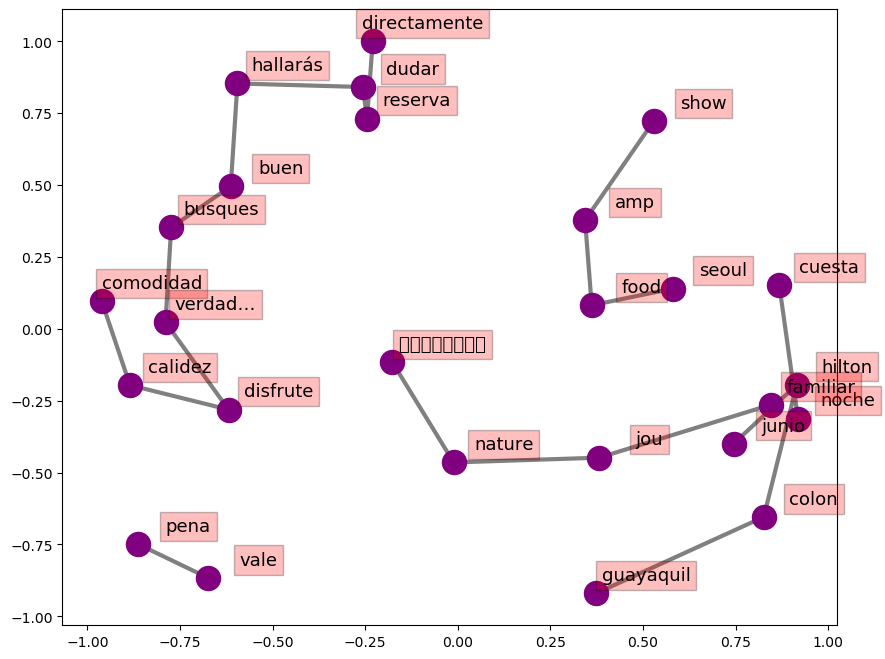

In [89]:
#Create network
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## Nube de palabras

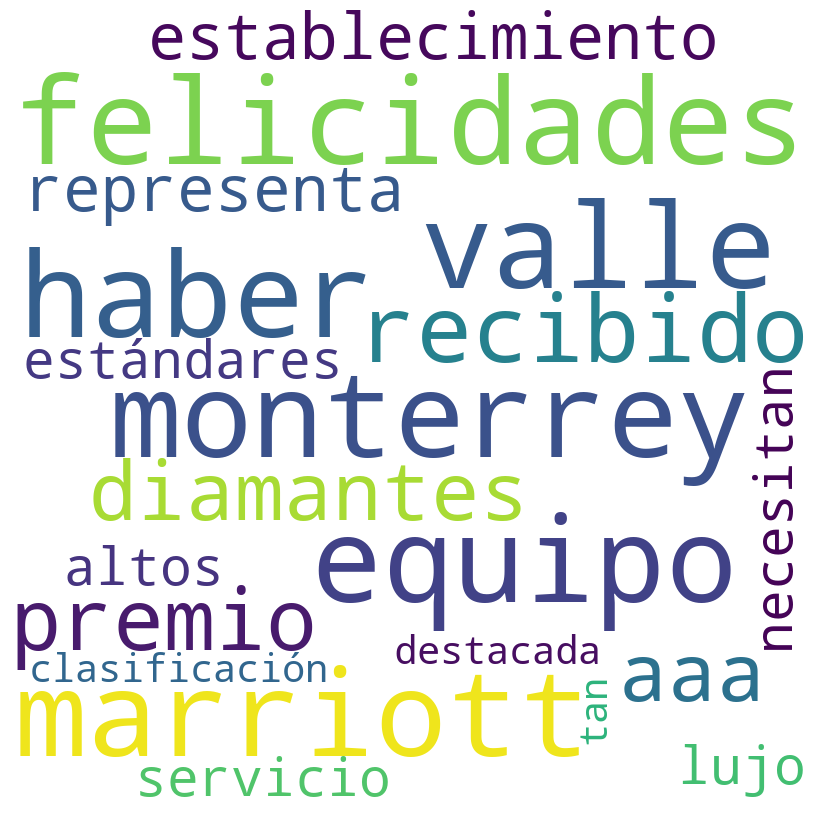

In [90]:
# Nube de palabras
for Palabras in tweets_ss_nc:
    Palabras += str(Palabras+' ')
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', #'black', 
                max_words=100,
                min_font_size = 10).generate(Palabras) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)#, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Modelo pre entrenado

In [92]:
import nltk

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
translator = Translator() #Google Translate

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...


In [93]:
tweets = [' '.join(word) for word in words_in_tweet]
tweet_df = pd.DataFrame(data=tweets, 
                columns=["tweet",])
tweet_df.head()

,tweet
0,los comensales de hoy en día buscan ambiente y...
1,¡crea momentos de calidad en familia en nuestr...
2,rt que maravilla valle de guadalupe bc sus pai...
3,en la entrevista dijo q jugar en la mls le va ...
4,en un mundo en constante cambio la creatividad...


In [95]:
#In this code, I've wrapped the translator.translate() call inside the translate_text() function, which handles the ReadTimeout exception and returns an empty string if the exception occurs. 
#This ensures that the process continues uninterrupted even if a timeout occurs while translating the text.
import requests
from googletrans import Translator
from nltk.sentiment import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
translator = Translator()

def translate_text(text):
    try:
        translation = translator.translate(text, dest='es').text
        return translation
    except requests.exceptions.ReadTimeout:
        return ''

tweet_df['translation'] = tweet_df['tweet'].apply(lambda x: translate_text(x))
tweet_df['score'] = tweet_df['translation'].apply(lambda x: sid.polarity_scores(x)["compound"])
tweet_df['sentimiento'] = tweet_df['score'].apply(lambda x: 'pos' if x >= 0 else 'neg')
tweet_df.drop(columns=['translation'], inplace=True)
tweet_df.head()

,tweet,score,sentimiento
0,los comensales de hoy en día buscan ambiente y...,0.0,pos
1,¡crea momentos de calidad en familia en nuestr...,0.0,pos
2,rt que maravilla valle de guadalupe bc sus pai...,0.0,pos
3,en la entrevista dijo q jugar en la mls le va ...,0.0,pos
4,en un mundo en constante cambio la creatividad...,0.0,pos


c:\Users\marti\anaconda3\envs\curso_nlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



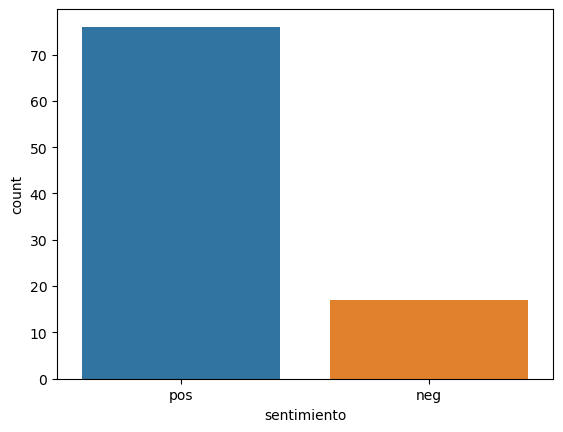

In [97]:
sns.countplot(tweet_df.sentimiento)
plt.show()